### MicroVision 

#### Generating Semantic Log Template Embeddings

In [1]:
import os

if os.getcwd() == '/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/microvision/notebooks':
    os.chdir('/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/microvision')
    print("Changed!!")

print("Current working directory:", os.getcwd())

os.environ["TOKENIZERS_PARALLELISM"] = "false"

Changed!!
Current working directory: /Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/microvision


In [2]:
%pip install pandas numpy tqdm matplotlib sentence-transformers chromadb --quiet
%pip install rapidfuzz streamlit --quiet
%pip install umap-learn pyvis streamlit --quiet



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Loading the enriched Templates

In [3]:
import os
import pandas as pd

config = {
        "DATA_DIR": "data",
        "DATASET_NAME": "OpenStack",
        # "DATASET_LOG": "_full.log",
        "DATASET_LOG": "_2k.log",
        "STRUCTURED_CSV": "_structured.csv",
        "TEMPLATES_CSV": "_templates.csv",
        "INPUT_CSV": "_cleaned_templates.csv",
        "ENRICHED_CSV": "_enriched.csv",
        "PERSISTENCE_DIR": "persistence",
        "DRAIN_PATH": "drain3_state",
                
        "EMBEDDINGS_CSV": "_embeddings.csv",
        "CHROMA_PERSIST_DIR": "chroma",
        "COLLECTION_NAME": "_collection"
}


### Semantic Embeddings Initialization

##### Sentence Transformer used: *** sentence-transformers/multi-qa-mpnet-base-dot-v1 *** Initial Model used - ** all-MiniLM-L6-v2 **

In [4]:
from collections import Counter
import re
import ast
import pandas as pd
from typing import Optional, List

def merge_structured_metadata(
    cleaned_df: pd.DataFrame,
    structured_df: pd.DataFrame,
    output_path: str,
    ids_col: str = "template_ids",
    id_col_single: str = "template_id",
    semantic_col: str = "semantic_text",
    meta_cols: Optional[List[str]] = None,
    try_simple_remap: bool = True,
    try_fuzzy_remap: bool = True,
) -> pd.DataFrame:
    """Merge cleaned templates with structured metadata reliably.

    Steps:
    - Ensure `ids_col` exists (fall back to `id_col_single`).
    - Parse list-like strings safely (ast.literal_eval, comma-split).
    - Normalize template ids (strip quotes/brackets/whitespace, turn '123.0' -> '123').
    - Explode and left-join onto structured by normalized ids.
    - If enabled, attempt simple remapping heuristics for missing ids (numeric equivalents, common prefixes).
    - If enabled, attempt fuzzy remapping using RapidFuzz for remaining missing ids.
    - Aggregate metadata back per semantic_text producing `template_ids` list and chosen meta columns.

    Returns the aggregated DataFrame and writes to `output_path`.
    """
    # copy inputs
    cleaned = cleaned_df.copy()
    structured = structured_df.copy()

    # default meta_cols if not provided
    if meta_cols is None:
        meta_cols = [c for c in ["service", "component", "level", "timestamp"] if c in structured.columns]

    # helper: parse possible list-like values robustly
    def parse_list_like(x):
        if pd.isna(x):
            return []
        if isinstance(x, list):
            return x
        if isinstance(x, str):
            s = x.strip()
            if not s:
                return []
            # literal eval for python-like lists
            if s.startswith("[") and s.endswith("]"):
                try:
                    parsed = ast.literal_eval(s)
                    return list(parsed) if isinstance(parsed, (list, tuple)) else [parsed]
                except Exception:
                    s = s.strip('[]')
            # comma separated fallback
            if "," in s:
                return [p.strip() for p in s.split(",") if p.strip()]
            return [s]
        return [x]

    # helper: normalize ids to stable string form
    def normalize_tid(val: object) -> str:
        if pd.isna(val):
            return ""
        s = str(val).strip()
        # strip surrounding quotes/brackets
        s = s.strip("'\"[]")
        # collapse whitespace
        s = re.sub(r"\s+", " ", s)
        # convert floats like '123.0' -> '123'
        if re.fullmatch(r"\d+\.0+", s):
            try:
                s = str(int(float(s)))
            except Exception:
                pass
        return s

    # Ensure ids_col exists on cleaned
    if ids_col not in cleaned.columns:
        if id_col_single in cleaned.columns:
            cleaned[ids_col] = cleaned[id_col_single].apply(lambda v: [v] if not pd.isna(v) else [])
        else:
            raise KeyError(f"cleaned_df must contain '{ids_col}' or '{id_col_single}'")

    # parse and normalize
    cleaned[ids_col] = cleaned[ids_col].apply(parse_list_like)
    exploded = cleaned.explode(ids_col).rename(columns={ids_col: id_col_single}).reset_index(drop=True)
    exploded = exploded.dropna(subset=[id_col_single])
    exploded["_tid_raw"] = exploded[id_col_single]
    exploded[id_col_single] = exploded[id_col_single].apply(normalize_tid)

    # normalize structured
    if id_col_single not in structured.columns:
        raise KeyError(f"structured_df must contain '{id_col_single}' column")
    structured = structured.copy()
    structured["_tid_raw"] = structured[id_col_single]
    structured[id_col_single] = structured[id_col_single].apply(lambda v: normalize_tid('' if pd.isna(v) else v))

    # perform left join
    merged = exploded.merge(structured, on=id_col_single, how="left", suffixes=("", "_struct"))

    # report missing metadata
    primary_meta_col = next((c for c in meta_cols if c in merged.columns), None)
    no_meta = merged[primary_meta_col].isna().sum() if primary_meta_col is not None else 0
    if no_meta:
        print(f"⚠️ {no_meta}/{len(merged)} exploded rows had no matching metadata in structured_df.")

    # If enabled, try simple remapping heuristics for rows still missing metadata
    struct_by_id = structured.groupby(id_col_single).first()
    struct_ids = set(structured[id_col_single].astype(str).unique())

    if try_simple_remap and no_meta > 0:
        missing_mask = merged[primary_meta_col].isna() if primary_meta_col is not None else merged[id_col_single].isna()
        missing_rows = merged[missing_mask]
        missing_ids = sorted(set(missing_rows[id_col_single].astype(str).unique()))
        remap_map = {}
        # heuristics: numeric equivalent, strip known prefixes on structured side
        prefixes = ["template_", "tpl", "t"]
        for mid in missing_ids:
            if not mid:
                continue
            # numeric int fallback: try int(mid)
            try:
                m_int = int(float(mid))
                cand = str(m_int)
                if cand in struct_ids:
                    remap_map[mid] = cand
                    continue
            except Exception:
                pass
            # prefix stripping: if structured has an id that endswith(mid) -> use it
            found = None
            for sid in struct_ids:
                if sid.endswith(mid) and len(sid) - len(mid) <= 6:
                    found = sid
                    break
            if found:
                remap_map[mid] = found
                continue
            # try adding common prefixes to mid
            for p in prefixes:
                cand = p + mid
                if cand in struct_ids:
                    remap_map[mid] = cand
                    break

        if remap_map:
            # apply remap to merged rows that are missing
            print(f"Applying simple remap for {len(remap_map)} missing ids (heuristic)")
            merged["_remapped_tid"] = merged[id_col_single].map(lambda x: remap_map.get(str(x), x))

            # columns to bring back (skip id and raw)
            cols_to_map = [c for c in structured.columns if c not in (id_col_single, "_tid_raw")]

            # For each column, create mapping dict and apply via .map (aligned by key -> no length mismatch)
            for col in cols_to_map:
                mapping = struct_by_id[col].to_dict()
                # assign only where we were missing metadata
                merged.loc[missing_mask, col] = merged.loc[missing_mask, "_remapped_tid"].map(mapping)

            # recompute missing count and print
            no_meta_after = merged[primary_meta_col].isna().sum() if primary_meta_col is not None else 0
            print(f"After heuristic remap, missing metadata rows: {no_meta_after}/{len(merged)}")

            # clean up temporary column
            merged = merged.drop(columns=[c for c in ["_remapped_tid"] if c in merged.columns])

    # If enabled, try fuzzy remap for remaining missing ids
    if try_fuzzy_remap and (merged[primary_meta_col].isna().sum() if primary_meta_col is not None else 0) > 0:
        from rapidfuzz import process, fuzz
        # try:
        #     from rapidfuzz import process, fuzz
        # except Exception:
        #     try:
        #         import sys
        #         print('Installing rapidfuzz...')
        #         get_ipython().run_line_magic('pip', 'install rapidfuzz --quiet')
        #         from rapidfuzz import process, fuzz
        #     except Exception:
        #         print('Could not install rapidfuzz; skipping fuzzy remap')
        #         process = None
        #         fuzz = None

        if process is not None:
            # recompute missing mask and ids
            missing_mask = merged[primary_meta_col].isna() if primary_meta_col is not None else merged[id_col_single].isna()
            missing_ids = [m for m in sorted(set(merged.loc[missing_mask, id_col_single].astype(str).unique())) if m]
            struct_ids_list = list(structured[id_col_single].dropna().astype(str).unique())

            fuzzy_map = {}
            for mid in missing_ids:
                best = process.extractOne(mid, struct_ids_list, scorer=fuzz.ratio)
                if best is None:
                    continue
                cand, score, _ = best
                # conservative threshold
                if score >= 85:
                    fuzzy_map[mid] = cand

            if fuzzy_map:
                print(f"Applying fuzzy remap for {len(fuzzy_map)} missing ids (threshold=85)")
                merged["_remapped_tid_fuzzy"] = merged[id_col_single].map(lambda x: fuzzy_map.get(str(x), x))
                cols_to_map = [c for c in structured.columns if c not in (id_col_single, "_tid_raw")]
                for col in cols_to_map:
                    mapping = struct_by_id[col].to_dict()
                    merged.loc[missing_mask, col] = merged.loc[missing_mask, "_remapped_tid_fuzzy"].map(mapping)

                # recompute missing
                no_meta_after2 = merged[primary_meta_col].isna().sum() if primary_meta_col is not None else 0
                print(f"After fuzzy remap, missing metadata rows: {no_meta_after2}/{len(merged)}")
                merged = merged.drop(columns=[c for c in ["_remapped_tid_fuzzy"] if c in merged.columns])
            else:
                print('No high-confidence fuzzy matches (score>=85) found')

    # Final fallback: fill missing metadata by majority (mode) within the same semantic_text
    still_missing_mask = merged[primary_meta_col].isna() if primary_meta_col is not None else merged.isna().any(axis=1)
    if still_missing_mask.any():
        print('\nApplying semantic_text majority-fill fallback for remaining missing rows...')
        filled = merged[~merged[primary_meta_col].isna()] if primary_meta_col is not None else merged[~merged.isna().any(axis=1)]
        if not filled.empty:
            modes = {}
            for meta in meta_cols:
                mode_series = filled.groupby(semantic_col)[meta].agg(lambda s: Counter(s.dropna()).most_common(1)[0][0] if len(s.dropna())>0 else None)
                modes[meta] = mode_series.to_dict()
            for meta in meta_cols:
                merged.loc[still_missing_mask, meta] = merged.loc[still_missing_mask, semantic_col].map(modes[meta])
        after_mode = merged[primary_meta_col].isna().sum() if primary_meta_col is not None else 0
        print(f"After semantic-text majority fill: {after_mode}/{len(merged)} exploded rows missing primary metadata")

    # helper to produce unique-preserving lists
    def unique_list(series):
        flat = []
        for v in series.dropna().tolist():
            if isinstance(v, list):
                for it in v:
                    if it not in flat:
                        flat.append(it)
            else:
                if v not in flat:
                    flat.append(v)
        return flat

    # build aggregation dict
    agg_dict = {
        id_col_single: lambda s: unique_list(s),
        "occurrences": "first"
    }
    for c in meta_cols:
        if c in merged.columns:
            agg_dict[c] = lambda s, col=c: unique_list(s)

    aggregated = merged.groupby(semantic_col).agg(agg_dict).reset_index()
    # rename template_id -> template_ids
    aggregated = aggregated.rename(columns={id_col_single: "template_ids"})

    # write and return
    aggregated.to_csv(output_path, index=False)
    print(f"✅ Merged dataframe saved to {output_path}")
    return aggregated

# Example usage (uncomment to run):
# enriched_df = merge_structured_metadata(cleaned_df, structured_df, output_path=enriched_path)


In [ ]:
# PREPARING THE DATA FILES

cleaned_df = pd.read_csv(f"{config['DATA_DIR']}/{config['DATASET_NAME']}{config['DATASET_LOG']}{config['INPUT_CSV']}")
structured_df = pd.read_csv(f"{config['DATA_DIR']}/{config['DATASET_NAME']}{config['DATASET_LOG']}{config['STRUCTURED_CSV']}")
enriched_path = f"{config['DATA_DIR']}/{config['DATASET_NAME']}{config['DATASET_LOG']}{config['ENRICHED_CSV']}"

# print(cleaned_df.head())
# print(structured_df.head(2))

# FUNCTION THAT MERGED THE STRUCTURED DF AND THE CLEANED TEMPLATES

enriched_df = merge_structured_metadata(cleaned_df, structured_df, output_path=enriched_path)
print(enriched_df)


In [6]:
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# model_name = "all-MiniLM-L6-v2"
# model_name = "multi-qa-mpnet-base-dot-v1"
model_name = "all-mpnet-base-v2"
embedding_model = SentenceTransformer(model_name, device=device)
tokenizer = embedding_model.tokenizer
print(f"✅ Loaded Embedding model: {model_name}, Tokenizer: {tokenizer.name_or_path}, using device: {device}")

/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/microvision/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/microvision/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Loaded Embedding model: all-mpnet-base-v2, Tokenizer: sentence-transformers/all-mpnet-base-v2, using device: mps


In [7]:
# FUNCTION THAT ENCODES THE TEMPLATES AND STORES THEM IN CHROMADB

import numpy as np
from tqdm import tqdm
import chromadb

def encode_templates(
        input_df: pd.DataFrame,
        model,
        device,
        output_dir,
        collection_name,
        force_recompute: bool = False,
)-> tuple[np.ndarray, pd.DataFrame, chromadb.api.models.Collection.Collection]:
        
        os.makedirs(output_dir, exist_ok=True)
        emb_path = os.path.join(output_dir, "embeddings.npy")
        index_path = os.path.join(output_dir, "embeddings_index.csv")

        # 🔁 Auto-reload cached embeddings
        if not force_recompute and os.path.exists(emb_path) and os.path.exists(index_path):
                print("♻️  Reloading cached embeddings and index...")
                embeddings = np.load(emb_path)
                df_index = pd.read_csv(index_path)
                print(f"Loaded {len(df_index)} cached embeddings.")
                return embeddings, df_index
        

        print("🔍 Loading cleaned templates...")

        texts = input_df["semantic_text"].astype(str).tolist()

        # Auto-detect hardware
        if device.lower() in ["cuda", "mps"]:
                batch_size = 128; print(f"🚀 GPU detected — using {device.upper()}")
        else:
                batch_size = 64; print("🧠 Using CPU mode")
        
        print(f"🪄 Encoding {len(texts)} templates with batch size {batch_size}...")

        # Progressive encoding with tqdm
        embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches", unit="batch"):
                batch = texts[i : i + batch_size]
                emb = model.encode(
                        batch,
                        show_progress_bar=False,
                        convert_to_numpy=True,
                        normalize_embeddings=True,
                )
                embeddings.append(emb)
                
        embeddings = np.vstack(embeddings)

        # Save embeddings and index
        np.save(emb_path, embeddings)
        input_df.to_csv(index_path, index=False)

        print(f"✅ Saved embeddings → {emb_path}, ✅ Saved index → {index_path}")

        print("💾 Storing embeddings in ChromaDB...")
        chroma_dir = f"{output_dir}/{config['CHROMA_PERSIST_DIR']}"
        client = chromadb.PersistentClient(path=chroma_dir)  
        
        collection = client.get_or_create_collection(
                name=collection_name,
                metadata={"description": "Semantic template embeddings for MicroVision"}
        )
        # --- Include all relevant metadata fields ---
        exclude_cols = ["semantic_text"]  # we'll store text separately
        meta_cols = [c for c in input_df.columns if c not in exclude_cols]

        # Ensure all metadata are string-serializable
        for col in meta_cols:
                input_df[col] = input_df[col].apply(
                        lambda x: ", ".join(x) if isinstance(x, (list, set)) else str(x)
                )

        meta_dicts = input_df[meta_cols].astype(str).to_dict(orient="records")

        print('meta_cols:', meta_cols[:50])
        collection.add(
                embeddings=embeddings,
                ids=input_df["template_ids"].apply(lambda x: str(x)).tolist(),
                documents=texts,
                metadatas=meta_dicts
        )
        print(f"✅ Embeddings successfully stored in ChromaDB. Collection: {collection_name}")
        print(f"📦 ChromaDB storage path: {chroma_dir}")

        return embeddings, input_df, collection



In [8]:
persist_dir = f"{config['DATA_DIR']}/embeddings"
# chroma_persist = f"{config['DATA_DIR']}/embeddings/{config['CHROMA_PERSIST_DIR']}" 
collection_name = f"{config['DATASET_NAME']}{config['DATASET_LOG']}{config['COLLECTION_NAME']}"

embeddings, embindex_df, collection = encode_templates(
        input_df=enriched_df,
        model=embedding_model,
        device=device,
        output_dir=persist_dir,
        collection_name=collection_name,
        force_recompute=True
)


🔍 Loading cleaned templates...
🚀 GPU detected — using MPS
🪄 Encoding 21 templates with batch size 128...


Embedding batches: 100%|██████████| 1/1 [00:01<00:00,  1.01s/batch]



🔍 Loading cleaned templates...
🚀 GPU detected — using MPS
🪄 Encoding 21 templates with batch size 128...


Embedding batches: 100%|██████████| 1/1 [00:01<00:00,  1.01s/batch]



✅ Saved embeddings → data/embeddings/embeddings.npy, ✅ Saved index → data/embeddings/embeddings_index.csv
💾 Storing embeddings in ChromaDB...
✅ Embeddings successfully stored in ChromaDB. Collection: OpenStack_2k.log_collection
📦 ChromaDB storage path: data/embeddings/chroma
✅ Embeddings successfully stored in ChromaDB. Collection: OpenStack_2k.log_collection
📦 ChromaDB storage path: data/embeddings/chroma


/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/microvision/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/microvision/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


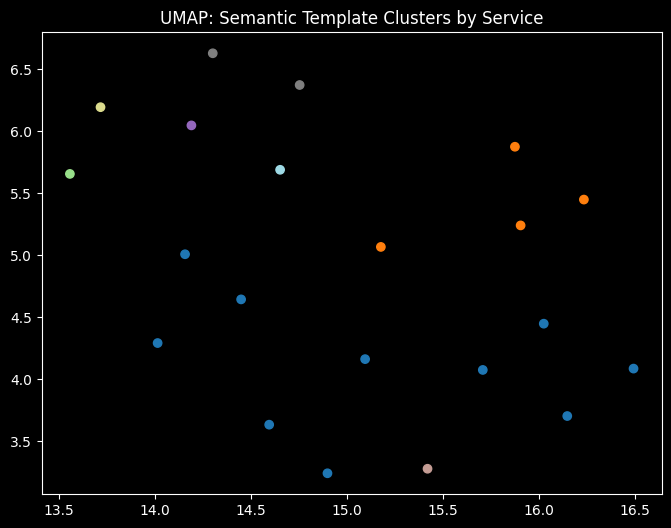

In [37]:
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Load your data
embeddings = np.load(f"{persist_dir}/embeddings.npy")
df_index = pd.read_csv(f"{persist_dir}/embeddings_index.csv")

reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=pd.factorize(df_index["service"])[0], cmap="tab20")
plt.title("UMAP: Semantic Template Clusters by Service")
plt.show()


In [ ]:
from chromadb import PersistentClient


EDGES_CSV = "edges_rag.csv"
SIM_THRESHOLD = 0.4  # cosine similarity threshold
TOP_K = 5    

# ---------- LOAD DATA ----------
def load_chroma_data(collection_name=collection_name):
    client = PersistentClient(path=f"{persist_dir}/chroma")
    collection = client.get_collection(collection_name)
    print(f"Loaded ChromaDB collection: {collection_name}")

    data = collection.get(include=["embeddings", "metadatas", "documents"])
    embeddings = np.array(data["embeddings"])
    metadatas = pd.DataFrame(data["metadatas"])
    documents = pd.Series(data["documents"], name="semantic_text")

    df = pd.concat([metadatas, documents], axis=1)
    print(f"✅ Loaded {len(df)} templates with embeddings.")
    return df, embeddings, collection

df, embeddings, collection = load_chroma_data()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import ast
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def compute_candidate_edges(df, embeddings, collection=None, threshold=SIM_THRESHOLD, top_k=TOP_K):
    """Compute retrieval-augmented edges between semantic templates using a hybrid score."""
    # allow using a global collection if not provided
    if collection is None:
        collection = globals().get("collection")
        if collection is None:
            raise ValueError("No 'collection' provided and no global 'collection' found.")

    # --- Explode grouped template_ids
    df = df.copy()
    # ensure template_ids is a parsed list
    if df["template_ids"].dtype == object:
        df["template_ids"] = df["template_ids"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # preserve original row index (maps to embeddings rows)
    df = df.reset_index().rename(columns={"index": "orig_idx"})
    df_exp = df.explode("template_ids").reset_index(drop=True)
    df_exp["template_ids"] = df_exp["template_ids"].astype(str)

    print("🔍 Computing hybrid Retrieval-Augmented Correlation edges...")
    # --- precompute fast lookup: template_id -> representative orig_idx (first occurrence) ---
    id_to_orig = df_exp.groupby("template_ids")["orig_idx"].first().to_dict()

    edges = []

    # iterate by exploded-row index; use orig_idx to access embeddings and to query Chroma
    for i in tqdm(range(len(df_exp)), desc="Computing hybrid edges"):
        row = df_exp.iloc[i]
        source_orig = int(row["orig_idx"])
        src_id = str(row["template_ids"])
        source_service = str(row.get("service", "unknown"))
        source_component = str(row.get("component", "unknown"))
        source_embedding = embeddings[source_orig]

        # query chroma for top-k similar docs (uses embedding)
        retrieved = collection.query(
            query_embeddings=[source_embedding],
            n_results=top_k,
            include=["metadatas", "distances", "documents"],
        )

        metas = retrieved.get("metadatas", [[]])[0]
        dists = retrieved.get("distances", [[]])[0] if retrieved.get("distances") else [None] * len(metas)

        for meta, distance in zip(metas, dists):
            # robustly extract template_ids from metadata (could be serialized)
            raw_ids = meta.get("template_ids") if isinstance(meta, dict) else None
            target_ids = []
            if raw_ids is None:
                # fallback: try documents field (not ideal) -- we skip when ids aren't present
                continue
            elif isinstance(raw_ids, list):
                target_ids = [str(x) for x in raw_ids]
            elif isinstance(raw_ids, str):
                s = raw_ids.strip()
                if s.startswith("[") and s.endswith("]"):
                    try:
                        parsed = ast.literal_eval(s)
                        if isinstance(parsed, (list, tuple)):
                            target_ids = [str(x) for x in parsed]
                        else:
                            target_ids = [str(parsed)]
                    except Exception:
                        s2 = s.strip("[]")
                        target_ids = [p.strip() for p in s2.split(",") if p.strip()]
                elif "," in s:
                    # comma-separated ids
                    target_ids = [p.strip() for p in s.split(",") if p.strip()]
                else:
                    target_ids = [s]
            else:
                target_ids = [str(raw_ids)]

            for tgt_id in target_ids:
                tgt_id = str(tgt_id)
                # fast lookup via precomputed map (O(1)) instead of filtering the exploded frame
                if tgt_id not in id_to_orig:
                    # no matching exploded row for that template id — skip
                    continue
                target_orig = int(id_to_orig[tgt_id])

                # compute cosine similarity on-demand between the two embeddings (faster & O(k) memory)
                # embeddings from the encoder were normalized; try dot product first and fallback to sklearn
                try:
                    score_cos = float(np.dot(source_embedding, embeddings[target_orig]))
                except Exception:
                    try:
                        score_cos = float(
                            cosine_similarity(
                                source_embedding.reshape(1, -1),
                                embeddings[target_orig].reshape(1, -1),
                            )[0, 0]
                        )
                    except Exception:
                        score_cos = 0.0

                # compute retrieval score (distance -> similarity)
                score_rag = float(1.0 - distance) if distance is not None else 0.0

                # hybrid score
                hybrid = score_cos * score_rag

                # apply threshold on hybrid score (if provided) to filter weak edges
                if threshold is not None and hybrid < threshold:
                    continue

                if src_id == tgt_id:
                    continue  # skip self-loops

                edges.append({
                    "source_template_id": src_id,
                    "target_template_id": tgt_id,
                    "source_service": source_service,
                    "source_component": source_component,
                    "target_service": str(meta.get("service", "unknown")),
                    "target_component": str(meta.get("component", "unknown")),
                    "score_cos": score_cos,
                    "score_rag": score_rag,
                    "hybrid_score": hybrid,
                })

    edges_df = pd.DataFrame(edges)
    edges_df.to_csv(EDGES_CSV, index=False)
    print(f"✅ Saved {len(edges_df)} inferred edges → {EDGES_CSV}")
    return edges_df

# Call with explicit collection parameter
edges_df = compute_candidate_edges(df, embeddings, collection)



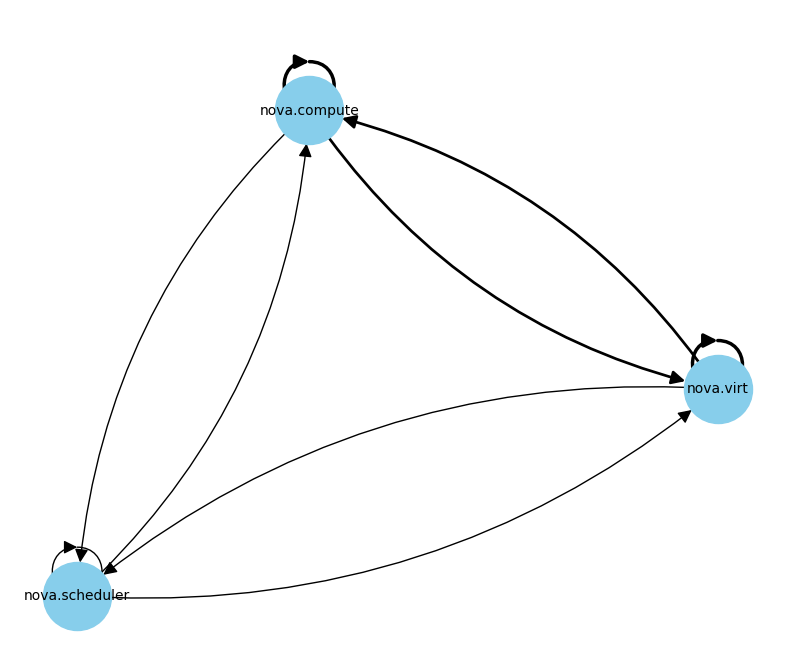

In [63]:
import networkx as nx
from pyvis.network import Network
import streamlit as st

# 1. FUNCTION TO BUILD THE GRAPHS

import ast
import pandas as pd

def build_service_graph(edges_df: pd.DataFrame, directed: bool = True, use_primary_only: bool = False) -> nx.Graph:
    def _parse_services(val):
        if pd.isna(val):
            return []
        if isinstance(val, (list, tuple)):
            return [str(v) for v in val]
        if isinstance(val, str):
            s = val.strip()
            if not s:
                return []
            # try python literal (e.g. "['a','b']")
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple)):
                    return [str(v) for v in parsed]
                return [str(parsed)]
            except Exception:
                # fallback: comma-separated
                if "," in s:
                    return [p.strip() for p in s.split(",") if p.strip()]
                return [s]
        return [str(val)]

    G = nx.DiGraph() if directed else nx.Graph()

    for _, row in edges_df.iterrows():
        src_services = _parse_services(row.get("source_service", None))
        tgt_services = _parse_services(row.get("target_service", None))

        if not src_services or not tgt_services:
            continue

        # optionally keep only the first service (primary) from multi-valued fields
        if use_primary_only:
            src_services = [src_services[0]]
            tgt_services = [tgt_services[0]]

        w = float(row.get("hybrid_score", 0.0))

        for src in src_services:
            for tgt in tgt_services:
                if src == "" or tgt == "":
                    continue
                if G.has_edge(src, tgt):
                    G[src][tgt]["weight"] += w
                else:
                    G.add_edge(src, tgt, weight=w)

    return G


# VISUALIZE THE GRAPH USING MATPLOTLIB

def visualize_matplotlib(
    G: nx.Graph,
    figsize=(10, 8),
    node_size=2400,
    node_color="skyblue",
    font_size=10,
    arrow_size=20,
    min_edge_width=1.0,
    max_edge_width=2.5,
    with_labels=True,
    seed= 42,
) -> None:

    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(facecolor= "white", figsize=figsize)
    # layout (stable with seed)
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=seed)

    # edge weights -> widths
    edges = list(G.edges(data=True))
    if edges:
        weights = np.array([d.get("weight", 1.0) for _, _, d in edges], dtype=float)
        # avoid negative/NaN
        weights = np.nan_to_num(weights, nan=0.0, posinf=0.0, neginf=0.0)
        if weights.max() == weights.min():
            widths = np.clip(weights, 0.0, None)
            # if all zero, use uniform width
            if widths.sum() == 0:
                widths = np.full(len(weights), (min_edge_width + max_edge_width) / 2.0)
            else:
                widths = np.full(len(weights), np.clip(widths.mean(), min_edge_width, max_edge_width))
        else:
            # linear normalize into [min_edge_width, max_edge_width]
            w_min, w_max = weights.min(), weights.max()
            widths = min_edge_width + (weights - w_min) * (max_edge_width - min_edge_width) / (w_max - w_min)
    else:
        widths = []

    # draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    # draw edges with or without arrows
    if G.is_directed():
        nx.draw_networkx_edges(
            G,
            pos,
            arrowstyle="-|>",
            arrowsize=arrow_size,
            width=widths if len(widths) else None,
            connectionstyle="arc3,rad=0.2",
            min_source_margin=24,  # margin from source node
            min_target_margin=24, 
        )
    else:
        nx.draw_networkx_edges(G, pos, width=widths if len(widths) else None)

    # labels
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=font_size)

    plt.title("Service Dependency Graph" + (" (directed)" if G.is_directed() else ""))
    plt.axis("off")
    plt.show()


visualize_matplotlib(build_service_graph(edges_df))